In [1]:
import numpy as np
import skimage.io
import skimage.transform
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil, pickle, os, random, matplotlib
from PIL import Image, ImageEnhance

# torch
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, TensorDataset 

# data logging
import configparser
import logging
import pandas as pd

# <strong>Main</strong>


## Data 
The data is converted into RGB tensors with skimage.io.imread()

<strong>Notice:</strong> pip install scikit-image 

### Training report


In [ ]:
class TrainingReporter:
    def __init__(self, file_name) -> None:
        self.file_name = file_name
        self.cols = ["Batch ID",  "Accuracy", "Margin Loss", "Reconstruction Loss", "Total Loss"]
        self.epoch, self.accuracy, self.marg_loss, self.recons_loss, self.total_loss  = [], [], [], [], []
        
        self.__write_rp()

    def __write_rp(self):
        df = pd.DataFrame(list(
            zip(self.epoch, self.accuracy, self.marg_loss, self.recons_loss,self.total_loss)), 
            columns=self.cols) 

    def record(self, data: dict) -> None: 
        self.epoch.append(data['Batch ID'])
        self.accuracy.append(data['Accuracy'])
        self.marg_loss.append(data['Loss']['Margin'])
        self.recons_loss.append(data['Loss']['Recon'])
        self.total_loss.append(data['Loss']['Total'])

    def test_dict(self):
        train_dict = {}
        a = [1,2,3,4,5]
        for entry in self.cols:
            print(entry)
            train_dict.update({entry: a})
        print(train_dict)
a = TrainingReporter("hello.csv")
a.test_dict()



In [ ]:
df1 = pd.DataFrame([['a', 'b'], ['c', 'd']],
                   index=['row 1', 'row 2'],
                   columns=['col 1', 'col 2'])
df1.to_excel("output.xlsx")

### (function) Pickling data 

In [3]:
def pickle_data(file, writeColumns=None):
    """
    Read/Write pickle training/testing data, models to avoid
    loading data again (time consuming)
    
    ---Params---

    file: path to pickle file

    writeColumns (array): variables to be saved to pickle file

    """
    if writeColumns is None:
        with open(file, mode="rb") as f:
            dataset = pickle.load(f)
            return tuple(map(lambda col: dataset[col], ['images', 'labels'])) # lambda(col) where columns are the inputs
    else:
        with open(file, mode="wb") as f:
            dataset = pickle.dump({"images": writeColumns[0], "labels": writeColumns[1]}, f)
            print("Data is saved in", file)
# lambda function: https://www.youtube.com/watch?v=BcbVe1r2CYc


### (function) Label the test dataset


In [ ]:
def label_test(src, csv_file, labeled_test_dir, NoOfCategories):
    """
    This function creates named folders corresponding to 43 categories
    and move the test images to these folders

    `csv_file` and `labeled_test_dir` should have already been in src directly 
    (create a blank folder to store labeled images)

    """
    # Remove the existing folders in the labeled test directory if there is any
    for filename in os.listdir(labeled_test_dir):
        file_path = os.path.join(labeled_test_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

    csv_dir = os.path.join(src, csv_file)
    SubTestDir = [os.path.join(labeled_test_dir, str(d)) for d in range(NoOfCategories)]
    
    # Create label folders
    [os.mkdir(test_d) for test_d in SubTestDir]

    testImageDir = pd.read_csv(csv_dir)['Path']
    testImageLabel = pd.read_csv(csv_dir)['ClassId']
    for idx in range(len(testImageLabel)):
        label = testImageLabel[idx]
        shutil.copy(os.path.join(src, testImageDir[idx]), SubTestDir[label])

labeled_test_dir = "D:\Programming Files\Python Files\Deep learning - traffic signs\German\LabeledTest"
# labeled_test_dir = r"C:\Users\lemin03\Documents\traffic_class\TrafficSignRec\German\LabeleTest" # BH   
src = "D:\Programming Files\Python Files\Deep learning - traffic signs\German" 
# src = r"C:\Users\lemin03\Documents\traffic_class\TrafficSignRec\German" # BH
csv_file = "Test.csv"
NoOfCats = 43

label_test(src, csv_file, labeled_test_dir, NoOfCats)


### (function) Load 

In [ ]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        # label_dir contains 61 catefories paths
        label_dir = os.path.join(data_dir, d)

        # list subdirectories within each of the 61 categories
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".png")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(int(d))
    return images, labels

# ROOT_PATH = "D:\Programming Files\Python Files\Deep learning - traffic signs\German"
ROOT_PATH = r"C:\Users\lemin03\Documents\traffic_class\TrafficSignRec\German"

### Last execution 10:01PM 20/5/23
!!!: resized images are already normalized to [0,1] format

In [ ]:
# Load training dataset.
train_data_dir = os.path.join(ROOT_PATH, "Train")
first_train_images, first_train_labels = load_data(train_data_dir)
pickle_data(file = "primary_train_dataset", writeColumns = [first_train_images, first_train_labels] )

In [ ]:
# Apply constant resolution among train images and pickle them 
train_images, train_labels  = pickle_data(file = 'primary_train_dataset')

train_images = [ skimage.transform.resize(train_image, (32, 32), mode = "constant") 
                            for train_image in train_images ]

train_images = np.stack(train_images, axis = 0)

pickle_data(file = "primary32_train_dataset", writeColumns = [train_images, train_labels])

In [ ]:
# Load the test dataset
test_data_dir = os.path.join(ROOT_PATH, "LabeledTest")
first_test_images, first_test_labels = load_data(test_data_dir)
test_images, val_images, test_labels, val_labels = train_test_split(first_test_images, first_test_labels, 
                                                                        test_size=0.36, random_state=0)
pickle_data(file = "primary_test_dataset", writeColumns = [test_images, test_labels])
pickle_data(file = "primary_val_dataset", writeColumns = [val_images, val_labels])

In [ ]:
# Apply constant resolution among test,val images and pickle them 
test_images, test_labels  = pickle_data(file = 'primary_test_dataset')
val_images, val_labels  = pickle_data(file = 'primary_val_dataset')

test_images = [ skimage.transform.resize(test_image, (32, 32), mode = "constant") 
                            for test_image in test_images ]
val_images = [ skimage.transform.resize(val_image, (32, 32), mode = "constant") 
                            for val_image in val_images ]

test_images = np.stack(test_images, axis = 0)
val_images = np.stack(val_images, axis = 0)

pickle_data(file = "primary32_test_dataset", writeColumns = [test_images, test_labels])
pickle_data(file = "primary32_val_dataset", writeColumns = [val_images, val_labels])

### Load pickled data

In [24]:
# Program starts here if pickle folders are not updated
train_images, train_labels  = pickle_data(file = './Data/primary32_train_dataset')
test_images, test_labels  = pickle_data(file = './Data/primary32_test_dataset')
val_images, val_labels  = pickle_data(file = './Data/primary32_val_dataset')

In [25]:
print(train_images.shape)

(39209, 32, 32, 3)


### (function) Display images


In [ ]:
def display_images(images, labels, category=False, greyScale=False):
    """
    Display the first image of each label.
    
    category: set to True when only images within a category are displayed
    greyScale: set to True to display images in grey scale
    """

    if category:
        i = 1
        startIndex = labels.index(category)
        catImages = images[startIndex:(startIndex + labels.count(category))] #catImage = categoryImage
        
        plt.figure(figsize=(15, 15))
        for catImage in catImages[:24]:
            plt.subplot(8, 8, i)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(catImage)
            i += 1 
    else:
        unique_labels = set(labels) # Create a list contains only the labels (non-iterative)
    
        #Example: a = [1, 1, 1, 2, 2, 3]
        #set(a) >> {1,2,3}

        plt.figure(figsize=(15, 15))
        i = 1
        for label in unique_labels:
            image = images[labels.index(label)] # Pick the first image for each label.

        # object.index(element) returns the index of the element specified when it's first encountered
        # Example: a = [1, 1, 1, 3, 2, 2, 3]
        # a.index(3) = 3

            plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
            plt.xticks([])
            plt.yticks([])
            plt.title("Label {0} ({1})".format(label, labels.count(label))) # sign category and the # of its samples
            if greyScale is False:
                plt.imshow(image)
            else:
                plt.imshow(image, cmap=plt.cm.binary)
            i += 1
    plt.show()

### (function) Convert to grey scale, improve contrast

In [ ]:
from skimage import exposure

def preprocess_images(images):
    """
        - Convert RGB images to grey scale 
        - Normalize pixels to 0-1,
        - Improve the contrast with adaptive histogram localization
    """
     
    # Conver RGB -> grey scale
    images = 0.299 * images[:, :, :, 0] + 0.587 * images[:, :, :, 1] + 0.114 * images[:, :, :, 2]
    # Improve the contrast
    #images = exposure.equalize_adapthist(images)

    # Add ONE 3-D channel for grey scale
    images = images.reshape(images.shape + (1,)) 

    return images

1


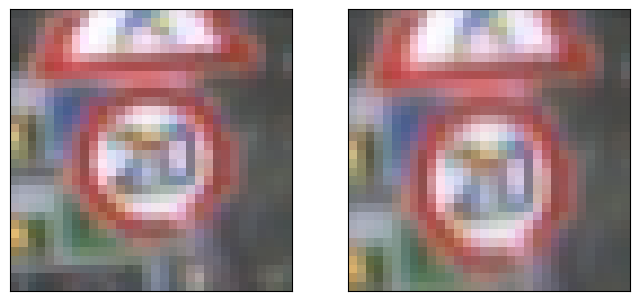

In [130]:
import random
import torchvision.transforms as T

a = torch.Tensor(train_images[0]) # RGB images
b = torch.Tensor(train_images[1])
c = torch.stack((a,b), dim=0).permute(0, 3, 1, 2) # create a 2 batchs with 1 image in each batch

class ImgAug:
    def __init__(self, batch_img, value):
        """
        Augment images by batch
        :param batch_img: [batch, C, H, W]
        :param value: the degree at which the imgs are transformed 
                      (recommended 0.3 -> 9 pixels)
        """

        self.batch_img = batch_img
        self.value = value
        aug_method = random.randint(0, 2)
        aug_dict = {
            '0': self._horizontal_shift(),
            '1': self._vertical_shift(),
            '2': self._rotate()
        }
        print(aug_method)
        augmented_batch = aug_dict[str(aug_method)]
        resized_img = self._fill(augmented_batch).permute(0, 2, 3, 1)
       
    @staticmethod
    def _fill(img):
        return T.Resize(size=(32,32))(img)

    def _horizontal_shift(self):
        ratio = random.uniform(-self.value, self.value)
        shift_by = int(ratio*(self.batch_img.size()[-1]))
        if ratio < 0: # shift to the right
            shifted_batch_img = self.batch_img[:, :, :, :shift_by]
        elif ratio > 0: # shift to the left
            shifted_batch_img = self.batch_img[:, :, :, shift_by:]
        else:
            shifted_batch_img = self.batch_img
        
        return shifted_batch_img

    def _vertical_shift(self):
        ratio = random.uniform(-self.value, self.value)
        shift_by = int(ratio*(self.batch_img.size()[-1]))
        if ratio < 0: # shift to the right
            shifted_batch_img = self.batch_img[:, :, :shift_by, :]
        elif ratio > 0: # shift to the left
            shifted_batch_img = self.batch_img[:, :, shift_by:, :]
        else:
            shifted_batch_img = self.batch_img

        return shifted_batch_img
    
    def _rotate(self):
        return T.RandomRotation(degrees=90)(self.batch_img)

shifted_batch = ImgAug(c, 0.3)


In [ ]:
a = train_images[0]
# print(a.shape)
a = 0.299 * a[:, :, 0] + 0.587 * a[:, :, 1] + 0.114 * a[:, :, 2]
print(a.shape)
a = exposure.equalize_adapthist(a)
a = a.reshape(a.shape + (1,)) 
plt.imshow(a,cmap=plt.cm.binary)


In [ ]:
# Display all images 
display_images(preprocess_images(train_images, improveCon=True), train_labels, greyScale=True)

In [ ]:
# Display all images 
display_images(preprocess_images(train_images), train_labels)

### Classes distribution

In [ ]:
fig, ax = plt.subplots()
n_classes = len(set(train_labels))
values, bins, patches = ax.hist(train_labels, n_classes)
ax.set_xlabel("Classes")
ax.set_ylabel("Number of images")

## Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

X_train = train_images

train_datagen = ImageDataGenerator()
inference_datagen = ImageDataGenerator()
train_datagen_augmented = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(X_train)
train_datagen_augmented.fit(X_train)
fig = plt.figure()
n = 0
graph_size = 3

for x_batch, y_batch in train_datagen_augmented.flow(X_train, train_labels, batch_size=4):
    a=fig.add_subplot(graph_size, graph_size, n+1)
    greyBatch = preprocess_images(x_batch)
    print(greyBatch[0].shape)
    imgplot = plt.imshow(greyBatch[0])
    plt.xticks([])
    plt.yticks([])
    plt.title("Label:{}".format(y_batch[0]))
    n = n + 1
    if n > 8:
        break
# plt.show()

In [2]:
import cv2
img = cv2.imread('test_img.png')
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img
img = rotation(img, 30)    
cv2.imshow('Result', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Model


### Capsule layer attributes
TODO:
- build a simple conv layer: DONE (first conv layer with relu)
- build capsule's functions (squash, routing)
- build primary and secondary capsnet
- fully connected layer for reconstruction
- loss functions
- add visualizations to track the changes in prior logits, training loss

In [11]:
# Currently this network only supports grey scale imgage due to fully connected reconstruction layer

from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

logging.basicConfig(filename='caps_net.log', filemode='w', format='%(asctime)s: %(message)s', level=logging.DEBUG)

config = configparser.ConfigParser()
config.read(
    r'D:\Programming Files\Python Files\Deep learning - traffic signs\src\capsnet_config.ini'
    )

# General info
num_class = int(config['network']['num_class'])
img_channels = int(config['network']['image_channels'])
batch_size = int(config['network']['batch_size'])
learning_rate = float(config['network']['lr'])
epochs = int(config['network']['epochs'])

train_num = torch.tensor(train_images).size()[0]
valid_num = torch.tensor(val_images).size()[0]
test_num = torch.tensor(test_images).size()[0]

# Primary caps
primary_num_caps = int(config['primary_caps']['num_caps'])
primary_channels = int(config['primary_caps']['channels'])

# Digit caps
digit_num_caps = num_class
digit_channels = int(config['digit_caps']['channels'])
num_iterations = int(config['network']['num_routing_iter'])

# Loss hyper params
m_plus = float(config['loss']['m_plus'])
m_minus = float(config['loss']['m_minus'])
lmbd = float(config['loss']['lambda'])
regularization_factor = float(config['loss']['regularization_factor'])


shuffeled_train_images, shuffeled_train_labels = shuffle(train_images, train_labels, random_state=0)
demo_train_images = shuffeled_train_images[0:100]
demo_train_labels = shuffeled_train_labels[0:100]
X_train = demo_train_images

train_datagen = ImageDataGenerator()
inference_datagen = ImageDataGenerator()
train_datagen_augmented = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    )


def squash(vector, axis=-1 ,epsilon=1e-7, squash=True):
        """
        normalize the length of the vector by 1
        `vector`: the muliplication of coupling coefs and prediction vectors sum [ c(ij)u^(j|i) ]
        `axis`: the axis that would not be reduced
        'epsilon`: a workaround to prevent devision by zero
        """
        squared_norm = torch.sum(torch.square(vector), dim=axis, 
                                keepdim=True)
        safe_norm = torch.sqrt(squared_norm + epsilon)

        if squash:
            squash_factor = squared_norm / (1. + squared_norm)
            unit_vector = vector / safe_norm
            return squash_factor * unit_vector
        else:
            return safe_norm


class CapsLayers(nn.Module):
    """ 
    Args:
    :param num_conv: number of filters/convolutional unit per capsule (dimension of a capsule)
    :param num_capsules: number of primary/digit caps
    :param num_routing_nodes: number of possible u(i), 
                            set to -1 if it's not a secondary capsule layer
    :param in_channels: output convolutional layers of the prev layer
    :param out_channels: output convolutional layers of the current layer
    """
    def __init__(self, num_capsules: int, in_channels: int, out_channels: int, 
                 kernel_size=None, stride=None, num_routing_nodes=None ,num_iterations=None):
        super(CapsLayers, self).__init__()
        self.num_capsules = num_capsules
        
        self.num_iterations = num_iterations
        self.num_routing_nodes = num_routing_nodes
        if num_routing_nodes is not None:
            self.weights = nn.Parameter(torch.randn(
                                        self.num_routing_nodes, num_capsules, out_channels, in_channels))
            self.b = nn.Parameter(torch.zeros(
                                    self.num_routing_nodes, num_capsules, 1, 1))
        else:
            self.primary_caps = nn.ModuleList(nn.Conv2d(in_channels, out_channels, kernel_size, stride) 
                                                    for _ in range(num_capsules))

    def forward(self, inputs):
        """
        Feed foward function for non-reconstruction layer
        :param inputs: 
            for the primary caps, the inputs are convolutional layer pixels
            for digit caps, the inputs are n-D vectors from a primary cap
                where n is the # of filters for one capsule  
            Required Paramteters:
            prior_logits(b) 
            primary layer prediction (requires u-layer 1 ouput, Weights)
        """
        if self.num_routing_nodes is not None:
            weights = self.weights[None, :, :, :].tile(inputs.size(0), 1, 1, 1, 1)
            b_ij = self.b[None, :, :, :].tile(inputs.size(0), 1, 1, 1, 1)
            inputs = inputs.tile(1, 1, self.num_capsules, 1, 1)
            
            # u_hat = [batch, num_routing_nodes, # digit_caps, digit_caps_dims, 1]
            u_hat = weights @ inputs 

            for i in range(self.num_iterations):
                c_ij = F.softmax(b_ij, dim=2)
                outputs = squash((c_ij*u_hat).sum(dim=1, keepdim=True))

                if i < self.num_iterations - 1 :
                    # v_j OR outputs = [batch, 1 -> num_routing_nodes, num_digit_caps, digit_caps_dims, 1 )]
                    b_ij +=  (b_ij + torch.transpose(u_hat, 3, 4) @ outputs.tile(1, self.num_routing_nodes, 1, 1, 1))

        else:
            outputs = [
                capsule(inputs)[:, None, :, :, :].permute(0, 1, 3, 4, 2) for capsule in self.primary_caps]
            outputs = torch.cat(outputs, dim=1)
            # u(i) = [batch, num_prim_caps*prim_caps_2D_size, prim_caps_output_dimension]
            outputs = outputs.view(outputs.size(0), -1, outputs.size(4)) 
            outputs = squash(outputs)[:, :, None, :, None]
        
        # outputs = [batch, 1, num_digit_caps/num_class, digit_caps_dims, 1 )]
        return outputs            


class CapsNet(nn.Module):
    """
        This class contains the full CapsNet architecture:
        Convolutional -> primary capsules -> digit capsules -> (3) fully connected
    """
    def __init__(self):
        """
        Params: 
        `inputs`: a 4D tensor (grey scale or RGB)
        """
        super(CapsNet, self).__init__()

        self.conv_1 = nn.Conv2d(img_channels, 256, 
                                kernel_size=9, stride=1)
        self.primary_caps = CapsLayers(primary_num_caps, 256, primary_channels, 
                                        kernel_size=5, stride=2)
        self.digit_caps = CapsLayers(digit_num_caps, primary_channels, digit_channels, 
                                     num_routing_nodes=10*10*primary_num_caps, num_iterations=num_iterations)
        self.grey_scale_decoder = nn.Sequential(
                nn.Linear(digit_channels*digit_num_caps, 576),
                nn.ReLU(),
                nn.Linear(576, 1600),
                nn.ReLU(),
                nn.Linear(1600, 1024),
                nn.Sigmoid(),
        )

        self.RGB_decoder = nn.Sequential(
                nn.Upsample(size=(8, 8)),
                nn.Conv2d(16, 4, 3, padding='same'),
                nn.ReLU(),

                nn.Upsample(scale_factor=2),
                nn.Conv2d(4, 8, 3, padding='same'),
                nn.ReLU(),

                nn.Upsample(scale_factor=2),
                nn.Conv2d(8, 16, 3, padding='same'),
                nn.ReLU(),

                nn.Conv2d(16, 3, 3, padding='same'),
                nn.Sigmoid()
        )

    def forward(self, images, labels=None): # labels should be applied `one_hot` function
        conv_1_ouputs = F.relu(self.conv_1(images))
        primary_caps_outputs =  self.primary_caps(conv_1_ouputs) #TODO: check again the size of conv1ouputs to 
        # verify capsules takes the correct size (since conv outputs has size [b, v, h, w])
        digit_caps_outputs = self.digit_caps(primary_caps_outputs).squeeze(1)
        
        assert list(digit_caps_outputs.size()) == [images.size()[0], num_class, digit_channels, 1]
               
        v_norm = squash(digit_caps_outputs, axis=-2, squash=False)
        v_prob = F.softmax(v_norm, dim=1)

        self.img = images
        self.v_norm = v_norm

        idx = torch.zeros(images.size()[0], 1, 1)
        # Masking
        if labels is None: # Testing mode
            _, idx = torch.max(v_prob, dim=1)
            labels = torch.eye(num_class).index_select(dim=0, index = idx.squeeze())

        #masked_v = [batch_size, digit_channels*classes])
        masked_v = (labels[:, :, None, None] * digit_caps_outputs).view(images.size(0), -1)
        
        # Reconstruction
        if images.size()[1] == 1:
            reconstructed_img = self.grey_scale_decoder(masked_v) # [batch, 32x32]

        else:
            linear_trans = nn.Linear(digit_channels*digit_num_caps, 400)
            fc_out = linear_trans(masked_v)
            reconstructed_img = self.RGB_decoder(fc_out) # [batch, channel, height, width]

        logging.debug(f'Capsule layer pred / batch: {idx}')

        return int(idx), reconstructed_img 
        

    def loss_fn(self, reconstructed_img, labels):
        # Margin loss
        max_1 = F.relu(m_plus - self.v_norm)
        max_2 = F.relu(self.v_norm - m_minus)
        T_k = labels[:, :, None, None]
        
        L_k = T_k * torch.square(max_1) + lmbd * (1 - T_k) * torch.square(max_2)

        assert L_k.size() == self.v_norm.size()
        margin_loss = L_k.sum(dim=1).mean()
        
        # Reconstruction loss
        reconstruction_loss_obj = nn.MSELoss()

        # original_img = [batch size, flatten image (pixels are flatten into arrays)]
        original_img = self.img.view(batch_size, -1)
        reconstruction_loss = reconstruction_loss_obj(reconstructed_img, original_img)
        
        total_loss = margin_loss + regularization_factor * reconstruction_loss

        return margin_loss, reconstruction_loss, total_loss


def train(model, train_loader, optimizer, device):
    # plot_batch = plt.figure()
    n = 0
    model.train() # set the model to training mode
    for batch_idx in range(train_num//batch_size):
        # plot_batch.add_subplot(10, 10, n+1)
        batch = next(train_loader)
        
        x_batch, y_batch = batch
        # plt.imshow(x_batch[0])
        y_batch = torch.Tensor(y_batch)
        y_batch = torch.nn.functional.one_hot(y_batch.to(torch.int64), num_classes=43)

        x_batch = torch.Tensor(preprocess_images(x_batch))
        x_batch = x_batch.permute(0, 3, 1, 2)# [batch_size, channels, height, width]
        
        if device == 'cuda':
            x_batch, y_batch = x_batch.cuda(), y_batch.cuda() 

        _, recons_img = model(x_batch, y_batch)
        margin_loss, recons_loss, total_loss = model.loss_fn(recons_img, y_batch)
        total_loss.backward()
        optimizer.step() # update the params to be optimized (weights, biases, routing weights)
     
        if batch_idx % (batch_size * 2) == 0:
            print(f'Batch {batch_idx+1}/{train_num//batch_size}')
        
        if n > 100:
            break
        n += 1 

def test(model, test_loader, device):
    """
    Can be used for both test and validation
    """
    model.eval()
    for idx, (batch_images, batch_labels) in enumerate(test_loader):
        if device == 'cuda':
            batch_images = batch_images.cuda()
            batch_labels = batch_labels.cuda()
        
        image = torch.Tensor(
            preprocess_images(image[None, :, :, :]).permute(0, 3, 1, 2),
            dtype=torch.float32)
        
        pred_idx, recons_img = model(image)
        
def data_loader(images: np.array, 
                labels: np.array, 
                batch_size: int,
                shuffle: bool) -> object:
    """
    :param images: 3D array [H, W, Channels]
    :param labels: 1D array
    :param batch_size: number of images per batch

    :return: an iterable object
    """
    images_tensor = torch.Tensor(images)
    labels_tensor = torch.Tensor(labels)

    dataset = TensorDataset(images_tensor, labels_tensor)
    data_loader = DataLoader(dataset, batch_size, shuffle=shuffle)

    return data_loader
if __name__ == '__main__':
    device_as_str = ("cuda" if torch.cuda.is_available() else "cpu")
    print(device_as_str, "will be used")

    model = CapsNet() #.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-5)

    train_loader = train_datagen_augmented.flow(X_train, demo_train_labels, batch_size=batch_size)

    # Validation dataset
    val_loader = data_loader(val_images, val_labels, batch_size, shuffle=False)
    train_loader = data_loader(train_images, train_labels, batch_size, shuffle=True)

    for epoch in range(epochs):  
        # train(model, train_loader, optimizer, device_as_str) 
        val_loss = test(model, val_loader, device_as_str)
        # scheduler.step(val_loss)

    # should put next_batch into train()


cpu will be used
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
ten

In [ ]:
from torch.utils.data import DataLoader, TensorDataset ,random_split

img = torch.Tensor(val_images)
labels = torch.Tensor(val_labels)

my_dataset = TensorDataset(img, labels)
test_loader = DataLoader(
        my_dataset,
        batch_size=10, shuffle=False)
# print(len(test_loader))
for data, target in test_loader:
    print(data.size(), target.size())

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

#Declare transform to convert raw data to tensor
transforms = transforms.Compose([
								transforms.ToTensor()
])

# Loading Data and splitting it into train and validation data
train = datasets.MNIST('', train = True, transform = transforms, download = True)
train, valid = random_split(train,[50000,10000])

# Create Dataloader of the above tensor with batch size = 32
trainloader = DataLoader(train, batch_size=32)
validloader = DataLoader(valid, batch_size=32)
print("!!!!!", len(trainloader))
# Building Our Mode
class Network(nn.Module):
	# Declaring the Architecture
	def __init__(self):
		super(Network,self).__init__()
		self.fc1 = nn.Linear(28*28, 256)
		self.fc2 = nn.Linear(256, 128)
		self.fc3 = nn.Linear(128, 10)

	# Forward Pass
	def forward(self, x):
		x = x.view(x.shape[0],-1) # Flatten the images
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return x

model = Network()
if torch.cuda.is_available():
	model = model.cuda()

# Declaring Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

# Training with Validation
epochs = 5
min_valid_loss = np.inf

for e in range(epochs):
	train_loss = 0.0
	for data, labels in trainloader:
		# Transfer Data to GPU if available
		if torch.cuda.is_available():
			data, labels = data.cuda(), labels.cuda()
		
		# Clear the gradients
		optimizer.zero_grad()
		# Forward Pass
		target = model(data)
		# Find the Loss
		loss = criterion(target,labels)
		# Calculate gradients
		loss.backward()
		# Update Weights
		optimizer.step()
		# Calculate Loss
		train_loss += loss.item()
	
	valid_loss = 0.0
	model.eval()	 # Optional when not using Model Specific layer
	for data, labels in validloader:
		# Transfer Data to GPU if available
		if torch.cuda.is_available():
			data, labels = data.cuda(), labels.cuda()
		
		# Forward Pass
		target = model(data)
		# Find the Loss
		loss = criterion(target,labels)
		# Calculate Loss
		valid_loss += loss.item()

	print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(trainloader)} \t\t Validation Loss: {valid_loss / len(validloader)}')
	print('@@@@@@', len(validloader))
	if min_valid_loss > valid_loss:
		print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
		min_valid_loss = valid_loss
		
		# Saving State Dict
		torch.save(model.state_dict(), 'saved_model.pth')


In [ ]:
digit_channels = 16
digit_num_caps = 43

grey_scale_decoder = nn.Sequential(
                nn.Linear(digit_channels*digit_num_caps, 576, device='cuda'),
                nn.ReLU(),
                nn.Linear(576, 1600, device='cuda'),
                nn.ReLU(),
                nn.Linear(1600, 1024, device='cuda'),
                nn.Sigmoid()
        )

RGB_decoder = nn.Sequential(
            nn.Upsample(size=(8, 8)),
            nn.Conv2d(16, 4, 3, padding='same'),
            nn.ReLU(),


            nn.Upsample(scale_factor=2),
            nn.Conv2d(4, 8, 3, padding='same'),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(8, 16, 3, padding='same'),
            nn.ReLU(),

            nn.Conv2d(16, 3, 3, padding='same'),
            nn.Sigmoid()
        )
inputs = torch.ones(2, 43, 16, 1).view(2, -1)
decoder = nn.Linear(digit_channels*digit_num_caps, 400)
decoded_v = decoder(inputs).view(2, digit_channels, 5, 5) #torch.Size([2, 16, 8, 8])

inputs2 = torch.ones(2, 43, 16, 1, device = 'cuda').view(2, -1)

output1 = RGB_decoder(decoded_v)
output2 = grey_scale_decoder(inputs2)
print(output1.size())
plt.imshow(output1[0].permute(1, 2, 0).detach().numpy())

In [ ]:
import tensorflow as tf

batch_size = 2

capsule_vector = tf.ones(shape=[2, 43, 16, 1])
capsule_vector = tf.reshape(capsule_vector, shape=[2, -1])
fc1 = tf.keras.layers.Dense(400)(capsule_vector)
fc1 = tf.reshape(fc1, shape=(batch_size, 5, 5, 16))
upsample1 = tf.image.resize(fc1, [8, 8])

print('11111',tf.shape(upsample1))
conv1 = tf.keras.layers.Conv2D(4, kernel_size=(3,3), activation=tf.nn.relu)(upsample1)
print('22222',tf.shape(conv1))

upsample2 = tf.image.resize(conv1, (16, 16))
conv2 = tf.keras.layers.Conv2D(8, (3,3), padding='same', activation=tf.nn.relu)(upsample2)

upsample3 = tf.image.resize(conv2, (32, 32))
conv6 = tf.keras.layers.Conv2D(16, (3,3), padding='same', activation=tf.nn.relu)(upsample3)

# 3 channel for RGG
logits = tf.keras.layers.Conv2D( 3, (3,3), padding='same', activation=None)(conv6)
decoded = tf.nn.sigmoid(logits, name='decoded')
print(tf.shape(decoded))

plt.imshow(decoded[0])

Demo (based on German dataset but matrix sizes are chosen on purpose to match MNIST)

In [ ]:
demo_conv = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=13, stride=1) #kernel = 9, stride = 1 for 10x10
primary_caps =  nn.ModuleList(nn.Conv2d(256, 8, 9, 2) for _ in range(32))#kernel = 5 or 6, stride = 2 for 10x10

def squash(vector, axis=-1, epsilon=1e-7, squash=True):
        """
        normalize the length of the vector by 1
        `vector`: the muliplication of coupling coefs and prediction vectors sum [ c(ij)u^(j|i) ]
        `axis`: the axis that would not be reduced
        'epsilon`: a workaround to prevent devision by zero
        """
        squaredNorm = torch.sum(torch.square(vector), dim=axis, 
                                keepdim=True)
        safeNorm = torch.sqrt(squaredNorm + epsilon)
        
        if squash:
                squashFactor = squaredNorm / (1. + squaredNorm)
                unitVector = vector / safeNorm
                return squashFactor * unitVector
        else:
                return squaredNorm

def test_routing(inputs, num_capsules, num_routing_nodes, num_iterations ):
        b = nn.Parameter(torch.zeros(num_routing_nodes, num_capsules, 1, 1))
        weights = nn.Parameter(torch.rand(num_routing_nodes, num_capsules, 16, 8))

        weights = weights[None, :, :, :].tile(inputs.size(0), 1, 1, 1, 1)
        b_ij = b[None, :, :, :].tile(inputs.size(0), 1, 1, 1, 1)
        inputs = inputs.tile(1, 1, num_capsules, 1, 1)
  
        # u_hat = [batch, num_routing_nodes, # digit_caps, digit_caps_dims, 1]
        u_hat = torch.matmul(weights, inputs)
    
        for i in range(num_iterations):
                c_ij = F.softmax(b_ij, dim=2)
                v_j = squash((c_ij*u_hat).sum(dim=1, keepdim=True))
                
                if i < num_iterations - 1 :
                        # v_j = [batch, 1 -> num_routing_nodes, num_digit_caps, digit_caps_dims, 1 )]
                        b_ij +=  (b_ij + torch.transpose(u_hat, 3, 4) @ v_j.tile(1, num_routing_nodes, 1, 1, 1))

        return v_j 

def main():
        a = torch.Tensor(train_images[0]) # RGB images
        b = torch.Tensor(train_images[1])
        c = torch.stack((a,b), dim=0) # create a 2 batchs with 1 image in each batch

        num_categories = 10
        conv_output = demo_conv(c.permute(0, 3, 1, 2)) # Notice: input is in form [batch, channel, height, width]
        # ouputs -> list: len(list) = num_caps, outputs elements -> tensor: size (1,8,10,10)
        caps_output = [
                (cap(conv_output))[:, None, :, :, :].permute(0, 1, 3, 4, 2) for cap in primary_caps]
        output = torch.cat(caps_output, dim=1)
        output = output.view(output.size(0), -1, output.size(4))
        output = squash(output)[:, :, None, :, None]
        # print(conv_output.size(), output.size())

        #routing
        v_j = test_routing(output, 10, 1152, 3).squeeze(1)
        v_j_norm = squash(v_j, axis=-2, squash=False)
        v_softmax = F.softmax(v_j_norm, dim=1)
        # if y is None:
        v_active, idx = torch.max(v_softmax, dim=1)
        y = torch.eye(10).index_select(dim=0, index = idx.squeeze())
        
        masked_v = (y[:, :, None, None] * v_j).view(batch_size, -1)

        # print(masked_v.size())
        print(idx.size())
        assert list(v_j.size()) == [c.size()[0], 10, 16, 1]
   
main()

# <strong>Miscellaneous</strong>

## Super() examples
use super to access the characteristics of other classes
Ex:
super().__init__(mammalName) is equivalent to Class1.__init_(self, mammalName)

### Example 1

In [ ]:
class Animal(object):
  def __init__(self, Animal):
    print(Animal, 'is an animal.')

class Mammal(Animal):
  def __init__(self, mammalName):
    print(mammalName, 'is a warm-blooded animal.')
    super().__init__(mammalName)

class NonMarineMammal(Mammal):
  def __init__(self, NonMarineMammal):
    print(NonMarineMammal, "can't swim.")
    super().__init__(NonMarineMammal)
   
class NonWingedMammal(Mammal):
  def __init__(self, NonWingedMammal):
    print(NonWingedMammal, "can't fly.")
    super().__init__(NonWingedMammal)

class Dog(NonMarineMammal, NonWingedMammal):
  def __init__(self):
    print('Dog has 4 legs.')
    super().__init__('Dog')
    
d = Dog()
print(d)
# bat = NonMarineMammal('Bat')

In [ ]:
class Parent:
  def __init__(self, *txt):
    # *args is not a must have input
    self.message = txt

  def printmessage(self):
    print(self.message)

  @staticmethod
  def printmessage2(text):
    print(text)


class Child(Parent):
  def __init__(self, txt: str, num):
    self.num = num
    super(Child, self).__init__()
    self.printmessage()
  
  def call_static(self, msg):
    self.printmessage2(msg)

x = Child("Hello, and welcome!", 2)

x.printmessage2("hi static") # another way to call Parent's method

### Example 2

In [ ]:
class Rectangle(object):
    def __init__(self, length, width):
        self.length = length
        self.width = width

    def area(self):
        return self.length * self.length

    def perimeter(self):
        return 2 * self.length + 2 * self.width

# Here we declare that the Square class inherits from the Rectangle class
class Square(Rectangle):
    def __init__(self, length_sqr):
        super().__init__(length_sqr, length_sqr)   # length_sqr = length and width of class Rectangle
Square(5).area()

### PIL module

In [ ]:

a = np.matrix('250 60 143; 90 100 40; 120 150 200')
im = Image.fromarray(a) # create a n image object as arrays
plt.imshow(im)

### Override

In [ ]:
class Employee:
    def __init__(self, name, base_pay):
        self.name = name
        self.base_pay = base_pay

    def get_pay(self):
        return self.base_pay


class SalesEmployee(Employee):
    def __init__(self, name, base_pay, sales_incentive):
        self.name = name
        self.base_pay = base_pay
        self.sales_incentive = sales_incentive

    def get_pay(self):
        return self.base_pay + self.sales_incentive


if __name__ == '__main__':
    john = SalesEmployee('John', 5000, 1500)
    print(john.get_pay())

    jane = Employee('Jane', 5000)
    print(jane.get_pay())

### Dimension visualization

In [ ]:
input_caps = 3
input_dims = 3
output_caps = 2
output_dims = 2
a = torch.Tensor(input_caps, input_dims , output_caps * output_dims)
b = torch.Tensor([ [[10], [30]], [[50], [70]] ])
print(b.shape)
plt.imshow(b, cmap =plt.cm.binary)
print(a, b)

!!! 4D requires diff inputs compared to 3D

In [ ]:
a = torch.randn(2,2,3)
b = torch.randn(2,2,2,3)
print(a)
print('---------------')
print(b)

### Convolutional operation

In [ ]:
# Python program to perform 2D convolution operation on an image
# Import the required libraries

'''input of size [N,C,H, W]
N==>batch size,
C==> number of channels,
H==> height of input planes in pixels,
W==> width in pixels.
'''

import torch
import torchvision
from PIL import Image
import torchvision.transforms as T

# Read input image
img = Image.open('dogncat.jpg')

# convert the input image to torch tensor
img = T.ToTensor()(img)
print("Input image size:", img.size()) # size = [3, 466, 700]

# unsqueeze the image to make it 4D tensor
img = img.unsqueeze(0) # image size = [1, 3, 466, 700]
# define convolution layer
# conv = nn.Conv2d(in_channels, out_channels, kernel_size)
conv = torch.nn.Conv2d(3, 3, 2)

# apply convolution operation on image
img = conv(img)
print(img.size())
plt.imshow(img[0,:,:,:].detach().numpy())


# squeeze image to make it 3D
img = img.squeeze(0) #now size is again [3, 466, 700]
# convert image to PIL image
img = T.ToPILImage()(img)

# display the image after convolution
img.show()

### Primary layer unit test

In [ ]:
def random_Tensor(size):
    return torch.rand(size, size, size)
a = [c for c in random_Tensor(3) ]
print(a)
a = torch.cat(a)
print(a)